In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('access_logs.csv')

# Ensure the 'Timestamp' column is parsed correctly
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')

# Extract features from the timestamp (Time Window)
data['Time_Window'] = data['Timestamp'].dt.floor('5min')  # Group into 5-minute intervals

# Time-based features: count requests per IP per time window
time_window_counts = data.groupby(['Time_Window', 'IP_Address']).size().reset_index(name='Request_Count')

# Bytes Sent per IP per time window
bytes_sent = data.groupby(['Time_Window', 'IP_Address'])['Bytes Sent'].sum().reset_index(name='Bytes_Sent')

# Merge request count and bytes sent to create a feature matrix
ddos_features = pd.merge(time_window_counts, bytes_sent, on=['Time_Window', 'IP_Address'])

# Additional features: frequency of HTTP methods (GET, POST, etc.)
method_counts = data.groupby(['Time_Window', 'IP_Address', 'Method']).size().unstack(fill_value=0)

# Combine method count features with the existing data
ddos_features = pd.merge(ddos_features, method_counts, on=['Time_Window', 'IP_Address'], how='left')

# Optionally, add status code distribution as a feature
status_code_counts = data.groupby(['Time_Window', 'IP_Address', 'Status Code']).size().unstack(fill_value=0)
ddos_features = pd.merge(ddos_features, status_code_counts, on=['Time_Window', 'IP_Address'], how='left')

# Fill missing values with 0 (for status code and methods that don't exist in certain time windows)
ddos_features = ddos_features.fillna(0)

# Convert all column names to strings to avoid mixed types
ddos_features.columns = ddos_features.columns.astype(str)

# Check the first few rows to inspect the data
print(ddos_features.head())

                Time_Window IP_Address  Request_Count  Bytes_Sent  DELETE  \
0 2024-11-07 11:20:00+00:00  127.0.0.1              6      632939       0   
1 2024-11-07 11:25:00+00:00  127.0.0.1             10      926893       0   
2 2024-11-07 11:30:00+00:00  127.0.0.1              5      121585       0   
3 2024-11-07 11:40:00+00:00  127.0.0.1              7      399595       0   
4 2024-11-07 11:45:00+00:00  127.0.0.1             10      865610       0   

   GET  PATCH  POST  200  201  204  302  400  401  500  
0    6      0     0    0    0    0    0    0    0    6  
1   10      0     0    0    0    0    0    0    0   10  
2    5      0     0    0    0    0    0    0    0    5  
3    7      0     0    0    0    0    0    0    0    7  
4   10      0     0    0    0    0    0    0    0   10  


Selected features for training:
   Request_Count  Bytes_Sent  DELETE  GET  PATCH  POST  200  201  204  302  \
0              6      632939       0    6      0     0    0    0    0    0   
1             10      926893       0   10      0     0    0    0    0    0   
2              5      121585       0    5      0     0    0    0    0    0   
3              7      399595       0    7      0     0    0    0    0    0   
4             10      865610       0   10      0     0    0    0    0    0   

   400  401  500  
0    0    0    6  
1    0    0   10  
2    0    0    5  
3    0    0    7  
4    0    0   10  
Number of detected anomalies: 2
Number of normal requests: 31


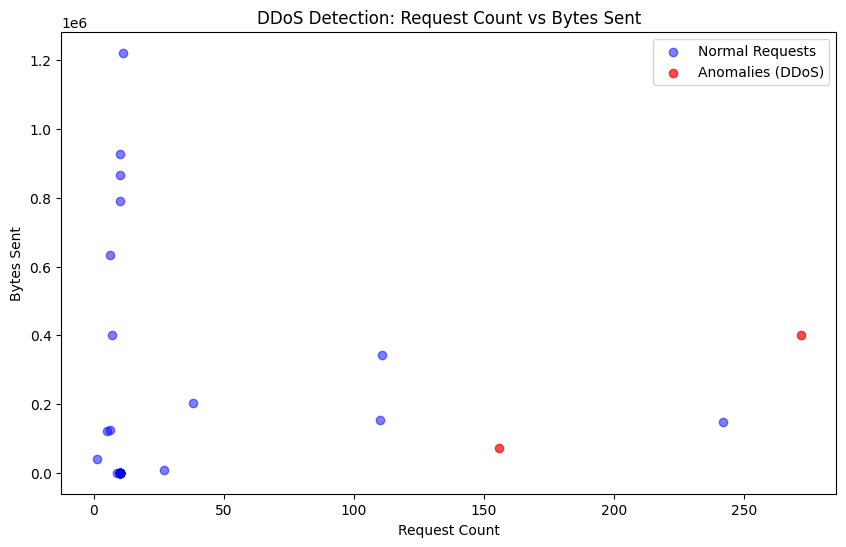

In [3]:

# Feature matrix for the model (excluding the Time_Window and IP_Address columns)
X = ddos_features.drop(columns=['Time_Window', 'IP_Address'])

# Ensure only numeric columns are selected for scaling
X_numeric = X.select_dtypes(include=[np.number])

# Display the selected features to verify correctness
print("Selected features for training:")
print(X_numeric.head()) 

# Standardize the features (important for distance-based algorithms like Isolation Forest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Initialize Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Train the Isolation Forest model on the feature matrix
iso_forest.fit(X_scaled)

# Predict anomalies (-1 for anomalies, 1 for normal data points)
ddos_features['Anomaly'] = iso_forest.predict(X_scaled)

# Count the number of anomalies detected
anomaly_counts = ddos_features['Anomaly'].value_counts()
print(f"Number of detected anomalies: {anomaly_counts.get(-1, 0)}")
print(f"Number of normal requests: {anomaly_counts.get(1, 0)}")

# Visualize anomalies (plot based on request count vs. bytes sent)@
plt.figure(figsize=(10, 6))
plt.scatter(ddos_features[ddos_features['Anomaly'] == 1]['Request_Count'],
            ddos_features[ddos_features['Anomaly'] == 1]['Bytes_Sent'], 
            color='blue', label='Normal Requests', alpha=0.5)

plt.scatter(ddos_features[ddos_features['Anomaly'] == -1]['Request_Count'],
            ddos_features[ddos_features['Anomaly'] == -1]['Bytes_Sent'], 
            color='red', label='Anomalies (DDoS)', alpha=0.7)

plt.title('DDoS Detection: Request Count vs Bytes Sent')
plt.xlabel('Request Count')
plt.ylabel('Bytes Sent')
plt.legend()
plt.show()
